# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
cal_train = pd.read_csv("../data/calendar_train.csv",parse_dates=['date']);
cal_train.head()

,listing_id,date,available,price
0,20872145,2018-09-21,f,NaN
1,20872145,2018-09-19,f,NaN
2,20872145,2018-09-18,f,NaN
3,20872145,2018-09-17,f,NaN
4,20872145,2018-09-16,f,NaN


<font color='blue'>
Looking at the top 5 observations we see that the response variable has missing values. We need to find out if there are only a few or many to determine how to resolve this issue.
</font>

In [4]:
cal_train.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734003 entries, 0 to 734002
Data columns (total 4 columns):
listing_id    734003 non-null int64
date          734003 non-null datetime64[ns]
available     734003 non-null object
price         309288 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 22.4+ MB


<font color='blue'>
Of the 734,003 observation more than half have a missing price. We will drop those observations.<br />
Also, we see that the `date` variable is a `datetime64[ns]` variable that the `parse_dates` function worked.
</font>

In [5]:
cal_train.dropna(inplace=True);
cal_train.info();
cal_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309288 entries, 123 to 733766
Data columns (total 4 columns):
listing_id    309288 non-null int64
date          309288 non-null datetime64[ns]
available     309288 non-null object
price         309288 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.8+ MB


,listing_id,date,available,price
123,20872145,2018-04-02,t,62.0
124,20872145,2018-04-01,t,59.0
125,20872145,2018-03-31,t,75.0
126,20872145,2018-03-30,t,71.0
127,20872145,2018-03-28,t,51.0


<font color='blue'>
We dropped all of the missing values and retained 309,288 observations.
</font>

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

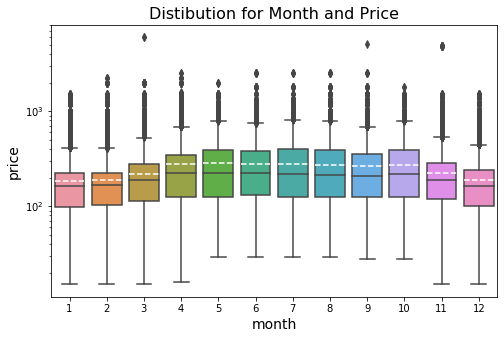

In [6]:
#your code here
fig, ax = plt.subplots(figsize=(8,5));
ax = sns.boxplot(x=cal_train['date'].dt.month, y='price', showmeans=True, meanline=True,
                 meanprops=dict(linestyle='--', linewidth=1.5, color='white'), data=cal_train);
ax.set(yscale='log');
ax.set_xlabel('month', fontsize=14);
ax.set_ylabel('price', fontsize=14);
ax.set_title('Distibution for Month and Price', fontsize=16);

<font color='blue'>
From the monthly boxplot we see that the median and average prices are highest from April (4) through october (10), which coinsides with the warm weather. Prices are lower, on average, during the winter months of December through February.
</font>

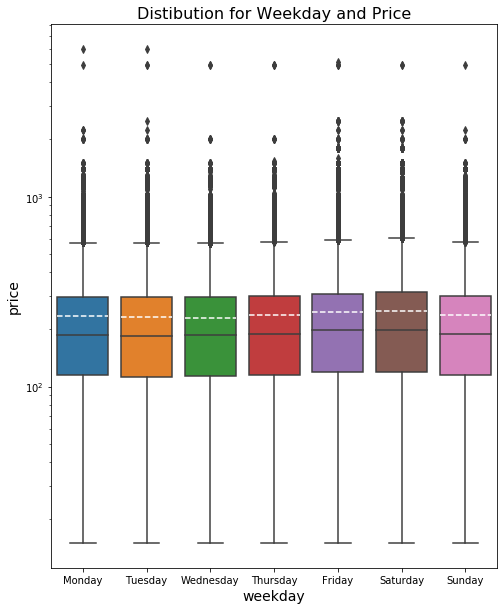

In [7]:
fig, ax = plt.subplots(figsize=(8,10));
ax = sns.boxplot(x=cal_train['date'].dt.weekday, y="price", showmeans=True, meanline=True,
                 meanprops=dict(linestyle='--', linewidth=1.5, color='white'), data=cal_train);
ax.set(yscale="log");
ax.set_xlabel('weekday', fontsize=14);
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);
ax.set_ylabel('price', fontsize=14);
ax.set_title('Distibution for Weekday and Price', fontsize=16);

<font color='blue'>
From the weekday boxplot we see that the median and average prices are highest Friday and Saturday nights, which are weekend nights.
</font>

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [8]:
#your code here
cal_train['date_diff']=(cal_train['date']-cal_train['date'].min()).dt.days;
cal_train['date_diff'].head()

123    178
124    177
125    176
126    175
127    173
Name: date_diff, dtype: int64

In [9]:
cal_test = pd.read_csv("../data/calendar_test.csv",parse_dates=['date']);
cal_test.dropna(inplace=True);
cal_test['date_diff']=(cal_test['date']-cal_test['date'].min()).dt.days;
cal_test.head()

,listing_id,date,available,price,date_diff
0,21205442,2018-09-28,t,138.0,357
1,5166870,2018-08-11,t,210.0,309
12,19455818,2018-04-13,t,869.0,189
14,20351854,2017-12-23,t,239.0,78
17,20622324,2018-02-09,t,259.0,126


<font color='blue'>
Test data loaded and transformed correctly.
</font>

### 1. Polynomials

In [10]:
#your code here
fit_lm_p2=sm.ols('price ~ date_diff + np.power(date_diff, 2)',data=cal_train[['price','date_diff']]).fit();
print('R Squared from model of degree 2       :',fit_lm_p2.rsquared);
print('R Squared from model of degree 2 (test):',r2_score(cal_test['price'],fit_lm_p2.predict(cal_test)));

R Squared from model of degree 2       : 0.018488573687432175
R Squared from model of degree 2 (test): 0.019180392770214327


In [11]:
fit_lm_p3=sm.ols('price ~ date_diff + np.power(date_diff, 2) + np.power(date_diff, 3)',data=cal_train[['price','date_diff']]).fit();
print('R Squared from model of degree 3       :',fit_lm_p3.rsquared);
print('R Squared from model of degree 3 (test):',r2_score(cal_test['price'],fit_lm_p3.predict(cal_test)));

R Squared from model of degree 3       : 0.03893294505042855
R Squared from model of degree 3 (test): 0.03875184567624912


In [12]:
fit_lm_p5=sm.ols('price ~ date_diff + np.power(date_diff, 2) + np.power(date_diff, 3) + np.power(date_diff, 4) + np.power(date_diff, 5)',data=cal_train[['price','date_diff']]).fit();
print('R Squared from model of degree 5       :',fit_lm_p5.rsquared);
print('R Squared from model of degree 5 (test):',r2_score(cal_test['price'],fit_lm_p5.predict(cal_test)));

R Squared from model of degree 5       : 0.04210025469611445
R Squared from model of degree 5 (test): 0.041738180644619205


In [13]:
fit_lm_p8=sm.ols('price ~ date_diff + np.power(date_diff, 2) + np.power(date_diff, 3) + np.power(date_diff, 4) + np.power(date_diff, 5) + np.power(date_diff, 6) + np.power(date_diff, 7) + np.power(date_diff, 8)',data=cal_train[['price','date_diff']]).fit();
print('R Squared from model of degree 8       :',fit_lm_p8.rsquared);
print('R Squared from model of degree 8 (test):',r2_score(cal_test['price'],fit_lm_p8.predict(cal_test)));

R Squared from model of degree 8       : -0.1701950752957504
R Squared from model of degree 8 (test): -0.1580092551250749


In [14]:
# create a varibale of mean price by date_diff
price_mean=cal_train.groupby('date_diff')['price'].mean();

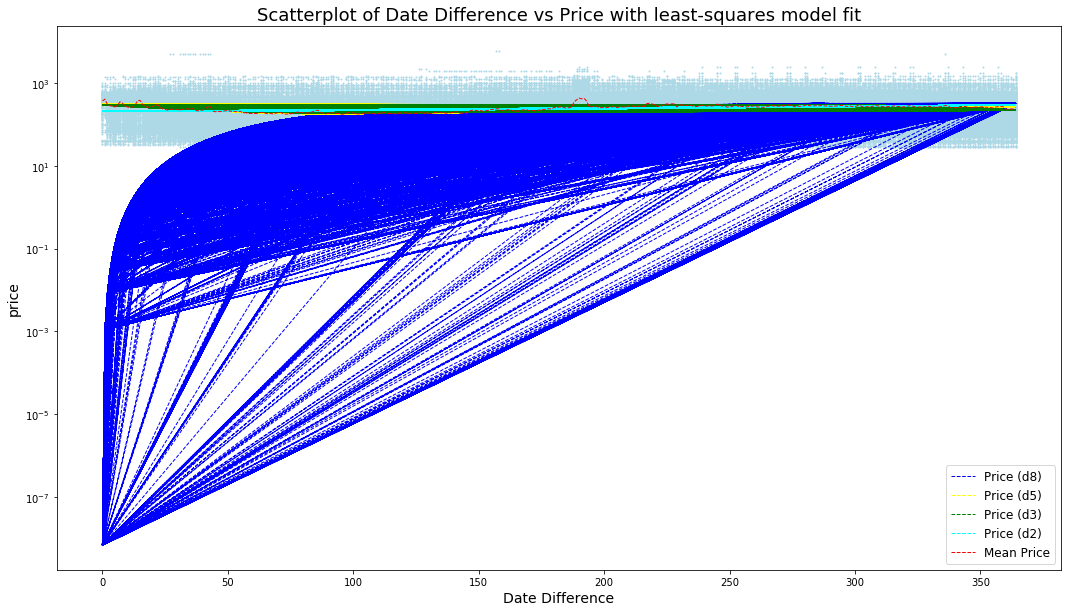

In [15]:
fig,ax=plt.subplots(figsize=(18,10));
ax.scatter(cal_train['date_diff'],cal_train['price'],s=1,c='lightblue');
ax.plot(cal_train['date_diff'],fit_lm_p8.get_prediction(cal_train).summary_frame()['mean'],ls='--',lw=1,c='blue',label='Price (d8)')
ax.plot(cal_train['date_diff'],fit_lm_p5.get_prediction(cal_train).summary_frame()['mean'],ls='--',lw=1,c='yellow',label='Price (d5)')
ax.plot(cal_train['date_diff'],fit_lm_p3.get_prediction(cal_train).summary_frame()['mean'],ls='--',lw=1,c='green',label='Price (d3)')
ax.plot(cal_train['date_diff'],fit_lm_p2.get_prediction(cal_train).summary_frame()['mean'],ls='--',lw=1,c='cyan',label='Price (d2)')
ax.plot(price_mean.index,price_mean,ls='--',lw=1,c='red',label='Mean Price');
ax.set(yscale='log');
ax.set_xlabel('Date Difference',fontsize=14);
ax.set_ylabel('price',fontsize=14);
ax.set_title('Scatterplot of Date Difference vs Price with least-squares model fit',fontsize=18);
ax.legend(loc='best',fontsize=12);

_your answer here_<br />
<font color='blue'>
The above scatterplot of date differences and prices, using a log scale, shows that the model with degree 8 polynimial has values that are near zero.
</font>

### 2. Degree 8 oddity
_your answer here_<br />
<font color='blue'>
The model with degree 8 polynomial has a negative R Squared. It also has predictions that are outside the range of the real price values.
</font>

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In [265]:
#your code here
X=cal_train[['date_diff']]
y=cal_train['price']

#base model
gam=LinearGAM(s(0)).fit(X,y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.7388
Link Function:                     IdentityLink Log Likelihood:                              -3510882.8282
Number of Samples:                       309288 AIC:                                           7021807.134
                                                AICc:                                         7021807.1369
                                                GCV:                                            33950.6043
                                                Scale:                                          33946.7042
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

/Applications/anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  import sys


In [268]:
#numpy.random.seed(seed=None)
np.random.seed(109)
lams=np.exp(np.random.rand(100)*8-3)
gam_par=LinearGAM(s(0)).fit(X,y)
gam_par.gridsearch(X,y,lam=lams)
gam_par.summary()

100% (100 of 100) |######################| Elapsed Time: 0:10:15 Time:  0:10:15


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      19.547
Link Function:                     IdentityLink Log Likelihood:                              -3510882.9889
Number of Samples:                       309288 AIC:                                          7021807.0718
                                                AICc:                                         7021807.0747
                                                GCV:                                             33950.589
                                                Scale:                                          33946.7268
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

/Applications/anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


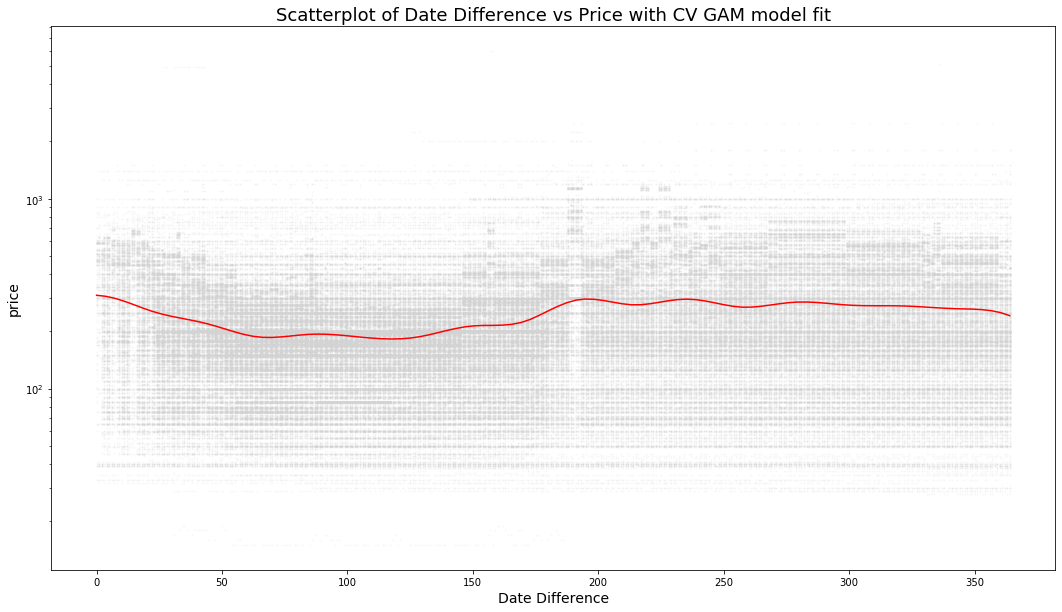

In [269]:
XX=gam_par.generate_X_grid(term=0)
fig,ax=plt.subplots(figsize=(18,10));
ax.scatter(X,y,s=1,c='lightgrey',alpha=0.1);
ax.plot(XX, gam_par.predict(XX),c='red');
ax.set(yscale='log');
ax.set_title('Scatterplot of Date Difference vs Price with CV GAM model fit',fontsize=18);
ax.set_xlabel('Date Difference',fontsize=14);
ax.set_ylabel('price',fontsize=14);

### 4. Effects of parameters
_your answer here_<br />
<font color='blue'>
Between the tuned GAM model and the base it appears that the parameters, such as AIC and GCV, have improved/decreased only negligibly. The lambdas are very similar, .6 versus 1.1406.
</font>

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [270]:
#your code here
cal_train['weekend']=np.where((cal_train['date'].dt.weekday.isin([4,5])),1,0)
cal_train.head()

,listing_id,date,available,price,date_diff,weekend
123,20872145,2018-04-02,t,62.0,178,0
124,20872145,2018-04-01,t,59.0,177,0
125,20872145,2018-03-31,t,75.0,176,1
126,20872145,2018-03-30,t,71.0,175,1
127,20872145,2018-03-28,t,51.0,173,0


In [271]:
X=cal_train[['date_diff','weekend']]
y=cal_train['price']

In [272]:
#weekend model
gam_wk=LinearGAM(s(0) + f(1),lam=1.1406).fit(X,y)
gam_wk.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.5469
Link Function:                     IdentityLink Log Likelihood:                              -3510510.1324
Number of Samples:                       309288 AIC:                                          7021063.3586
                                                AICc:                                         7021063.3618
                                                GCV:                                            33909.8769
                                                Scale:                                           33905.822
                                                Pseudo R-Squared:                                   0.0461
Feature Function                  Lam

/Applications/anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  This is separate from the ipykernel package so we can avoid doing imports until


_your answer here_<br />
<font color='blue'>
Using the tuned lambda from the above GAM model the parameters, such as AIC and GCV, have improved/decreased marginally. The Pseudo R-Squared improved from 0.045 to 0.0461.
</font>

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [88]:
#your code here
cal_train['price'].groupby(cal_train['date']).mean().nlargest(10);

date
2018-04-14    432.680761
2018-04-16    425.289528
2018-04-15    417.170404
2017-10-07    409.298701
2018-04-13    393.609047
2017-10-21    381.526515
2017-10-20    374.955932
2017-10-06    370.173410
2018-04-17    369.371060
2017-10-13    351.800725
Name: price, dtype: float64

In [90]:
cal_train.nlargest(20,'price');

,listing_id,date,available,price,date_diff,weekend
186681,16806556,2018-03-13,t,5993.0,158,0
186682,16806556,2018-03-12,t,5993.0,157,0
183807,12303347,2018-09-07,t,5143.0,336,1
439831,9992143,2017-11-18,t,4913.0,43,1
439832,9992143,2017-11-17,t,4913.0,42,1
439833,9992143,2017-11-16,t,4913.0,41,0
439869,9992143,2017-11-15,t,4913.0,40,0
439870,9992143,2017-11-14,t,4913.0,39,0
439871,9992143,2017-11-12,t,4913.0,37,0
439872,9992143,2017-11-11,t,4913.0,36,1


_your answer here_<br />
<font color='blue'>
1. I looked at the top 10 of average price by day and it appear that there is an expensive week in April and several days in october that are expensive.<br />
2. When I look at the top 10, expanded to 20, prices I see an oddity in several prices in November and a few prices in March and September. These prices are much higher than the next highest price of $2,500. It's also strange that all the dollar amounts end in 3 and could be a artifact of data collection. 
</font>

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [107]:
#your code here
list_train=pd.read_csv("../data/listings_train.csv");
list_train=pd.get_dummies(list_train, prefix=['room_type']);
list_train.rename(columns={'room_type_Entire home/apt': 'entire_home',
                           'room_type_Private room': 'private_room',
                           'room_type_Shared room': 'shared_room'}, inplace=True);
list_test=pd.read_csv("../data/listings_test.csv");
list_test=pd.get_dummies(list_test, prefix=['room_type']);
list_test.rename(columns={'room_type_Entire home/apt': 'entire_home',
                          'room_type_Private room': 'private_room',
                          'room_type_Shared room': 'shared_room'}, inplace=True);
list_train.head()

,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews,entire_home,private_room,shared_room
0,1,42.347956,-71.155196,1.0,1,1,52,1,65,365,26,0,1,0
1,85,42.349299,-71.083470,1.0,0,1,110,1,104,107,38,1,0,0
2,6,42.341902,-71.073792,1.0,1,1,67,45,56,322,9,1,0,0
3,1,42.319235,-71.105016,2.0,2,2,103,8,113,341,49,1,0,0
4,1,42.346452,-71.134896,1.0,0,1,8,24,82,41,13,1,0,0


In [108]:
from pandas.plotting import scatter_matrix

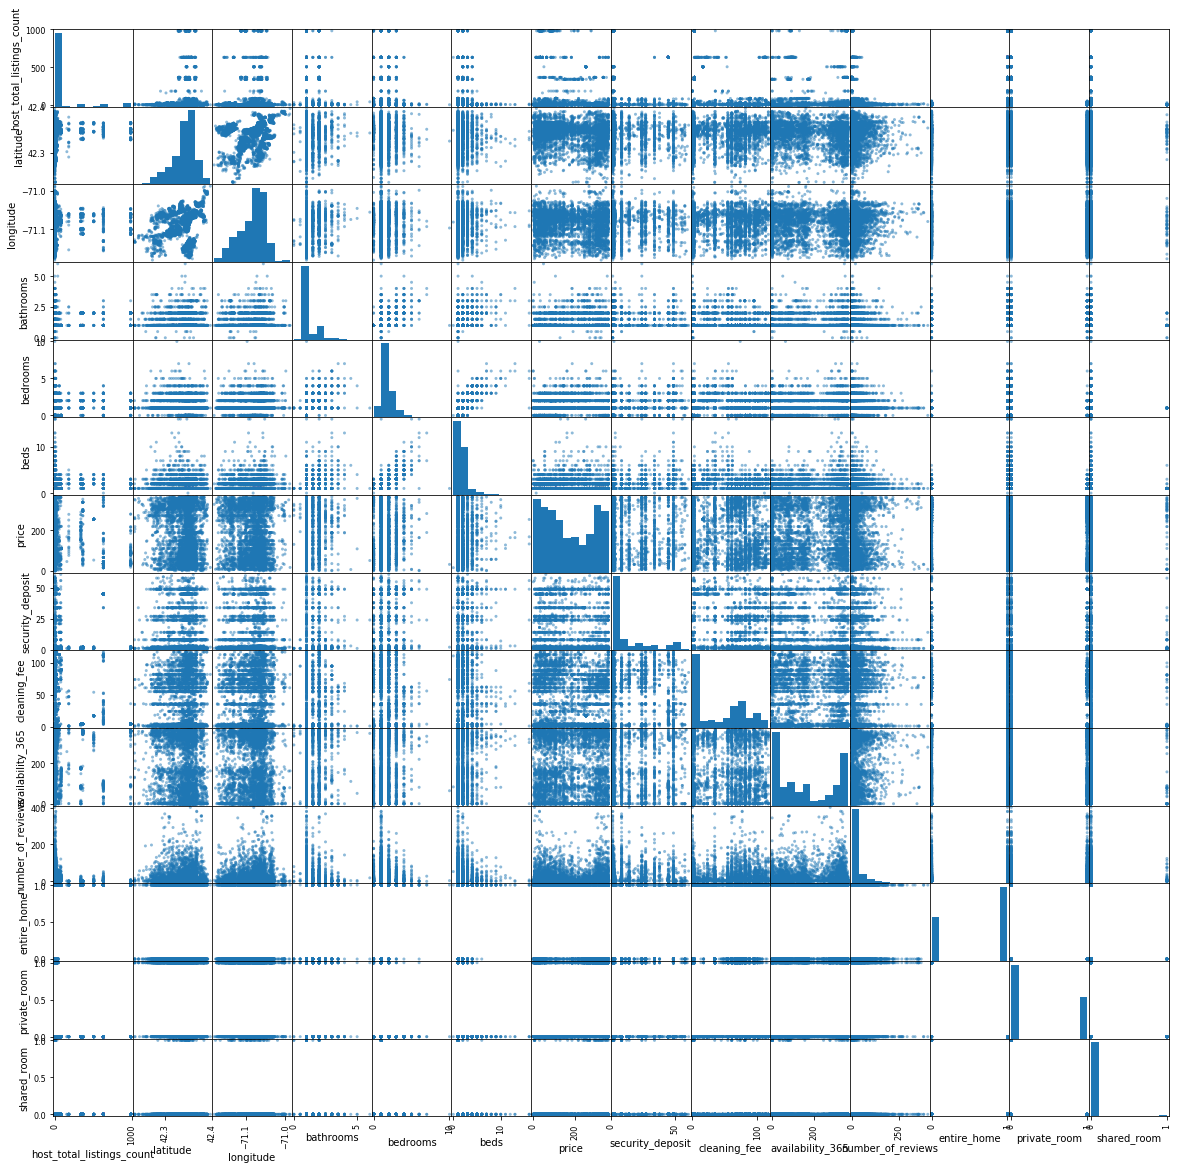

In [109]:
scatter_matrix(list_train,figsize=(20,20));

_your answer here_<br />
<font color='blue'>
Looking at the scatterplot matrix, at the vertical column of price, we see that price may have a nonlinear relationship with several predictors, such as latitude, longitude, availability_363 (looks like there are four quadrants of prices), and number of review.
</font>

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [210]:
#your code here
#poly=PolynomialFeatures(degree=3);
#list_train_poly=poly.fit_transform(list_train.loc[:,list_train.columns!='price']);
formula="price ~ "+" + ".join(list_train.columns.difference(['price','entire_home','private_room','shared_room']))+" + "+" np.power("+",2) + np.power(".join(list_train.columns.difference(['price','entire_home','private_room','shared_room']))+",2) + "+" np.power("+",3) + np.power(".join(list_train.columns.difference(['price','entire_home','private_room','shared_room']))+",3) + "+" + ".join(list_train[['private_room','shared_room']].columns)+""
#print(formula)

In [211]:
fit_lm_p=sm.ols(formula=formula,data=list_train).fit();
#fit_lm_p.summary()
print('R Squared from full model of degree 3       :',fit_lm_p.rsquared);
print('R Squared from full model of degree 3 (test):',r2_score(list_test['price'],fit_lm_p.predict(list_test)));

R Squared from full model of degree 3       : 0.2706476943830559
R Squared from full model of degree 3 (test): 0.23783233006036397


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_<br />
<font color='blue'>

</font>

In [31]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
# f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)
#your code here

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)


In [4]:
#your code here

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_